In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import data
import lib_bp_img_3d as bp
import pandas as pd
import matplotlib
%matplotlib inline

# Parâmetros para o cálculo de entropia e complexidade
dx, dy = 2, 2 # Dimensões de embedding
D = dx * dy

# Definir a semente global para reprodutibilidade
np.random.seed(42)

# Dimensões das imagens
width, height = 512, 512

# Aplicar os ruídos e armazenar as imagens e métricas
results_1 = []
results_2 = []
results_noise = []

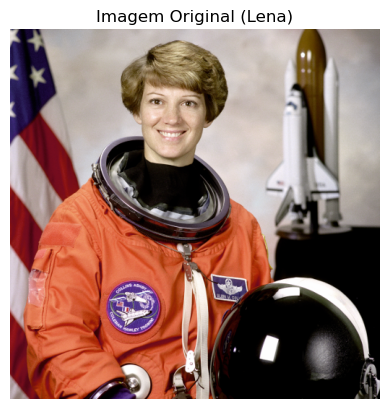

In [3]:
############################ Lena Astronauta #################################

# Carregar a imagem Lena
lena_image = data.astronaut()
# lena_image = cv2.cvtColor(lena_image, cv2.COLOR_BGR2RGB)

# Plotar a imagem original
plt.imshow(lena_image)
plt.axis("off")
plt.title("Imagem Original (Lena)")
plt.show()

# Calcular as probabilidades dos padrões ordinais
probs_lena = bp.bandt_pompe_method(lena_image, dx, dy)
    
# Calcular a entropia de Shannon normalizada
ent_lena = bp.shannon_entropy(probs_lena, normalized=True, sigma = D)
    
# Calcular a complexidade estatística
comp_lena = bp.complexity(probs_lena, ent_lena)

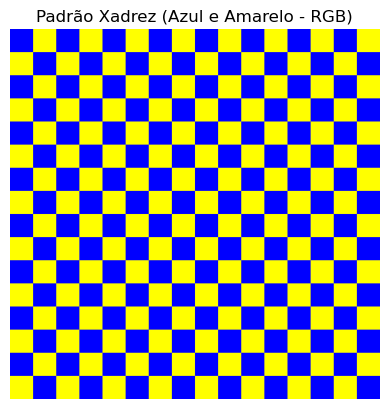

In [4]:
######################## Imagem de Padrão Xadrez #############################

block_size = 32

# Criar uma matriz para a imagem
chessboard_rgb = np.zeros((height, width, 3), dtype=np.uint8)

# Definir cores para o xadrez (em RGB)
color1 = [0, 0, 255]  # Azul
color2 = [255, 255, 0]  # Amarelo

# Preencher a matriz com o padrão xadrez
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        if (i // block_size + j // block_size) % 2 == 0:
            chessboard_rgb[i:i+block_size, j:j+block_size] = color1
        else:
            chessboard_rgb[i:i+block_size, j:j+block_size] = color2

# Exibir a imagem
plt.imshow(chessboard_rgb)
plt.axis('off')
plt.title('Padrão Xadrez (Azul e Amarelo - RGB)')
plt.show()

# Calcular as probabilidades dos padrões ordinais
probs_chess = bp.bandt_pompe_method(chessboard_rgb, dx, dy)
    
# Calcular a entropia de Shannon normalizada
ent_chess = bp.shannon_entropy(probs_chess, normalized=True, sigma = D)
    
# Calcular a complexidade estatística
comp_chess = bp.complexity(probs_chess, ent_chess)

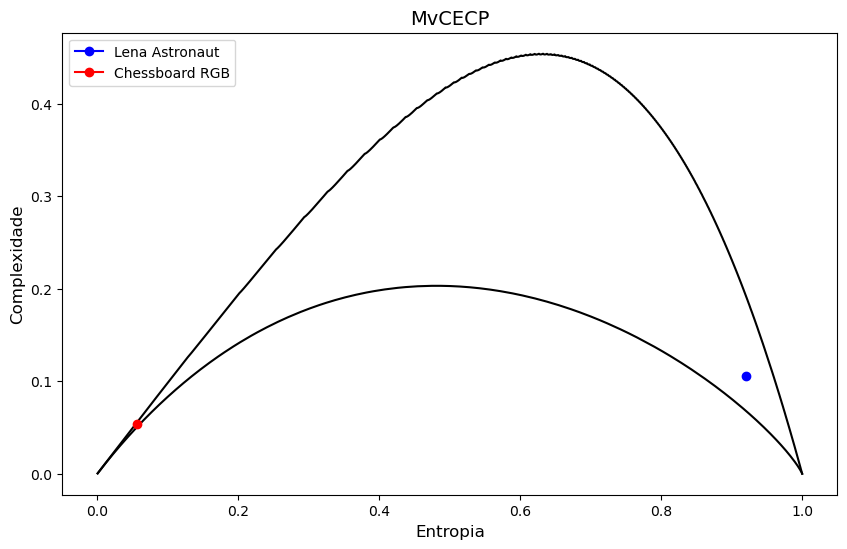

In [6]:
############################ Plots Base ######################################

fig, ax_main = plt.subplots(figsize=(10, 6))
    
# Adicionar limites no gráfico principal
bp.plot_3d(D)

# Plot no gráfico principal
ax_main.plot(ent_lena, comp_lena, marker='o', label='Lena Astronaut', color='blue')
ax_main.plot(ent_chess, comp_chess, marker='o', label="Chessboard RGB", color='red')

# Configurações do gráfico principal
ax_main.set_title("MvCECP", fontsize=14)
ax_main.set_xlabel("Entropia", fontsize=12)
ax_main.set_ylabel("Complexidade", fontsize=12)
ax_main.legend(loc="upper left", fontsize=10)

plt.show()    

In [9]:
# Funções de ruído adaptadas para percentual de ruído
def add_gaussian_noise(image, percent):
    std = percent / 100 * 255
    noise = np.random.normal(0, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def add_salt_and_pepper_noise(image, percent):
    prob = percent / 100
    noisy_image = image.copy()
    total_pixels = image.size
    salt_pixels = int(total_pixels * prob / 2)
    pepper_pixels = int(total_pixels * prob / 2)
    coords_salt = [np.random.randint(0, i - 1, salt_pixels) for i in image.shape]
    noisy_image[tuple(coords_salt)] = 255
    coords_pepper = [np.random.randint(0, i - 1, pepper_pixels) for i in image.shape]
    noisy_image[tuple(coords_pepper)] = 0
    return noisy_image

def add_uniform_noise(image, percent):
    intensity = percent / 100 * 255
    noise = np.random.uniform(-intensity, intensity, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def generate_perlin_noise(image, percent, scale=10):
    def f(t):
        return 6 * t**5 - 15 * t**4 + 10 * t**3  # Função de suavização

    height, width, _ = image.shape
    nx, ny = (width // scale) + 1, (height // scale) + 1  # Dimensão da grade

    # Gradientes aleatórios
    angles = 2 * np.pi * np.random.rand(nx, ny)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))

    # Coordenadas locais
    x = np.linspace(0, 1, scale, endpoint=False)
    y = np.linspace(0, 1, scale, endpoint=False)
    grid_x, grid_y = np.meshgrid(x, y)

    noise = np.zeros((height, width), dtype=np.float64)

    for i in range(nx - 1):
        for j in range(ny - 1):
            # Gradientes nas 4 esquinas
            g00 = gradients[i, j]
            g10 = gradients[i + 1, j]
            g01 = gradients[i, j + 1]
            g11 = gradients[i + 1, j + 1]

            # Coordenadas relativas
            dx, dy = grid_x, grid_y

            # Produtos internos
            n00 = g00[0] * dx + g00[1] * dy
            n10 = g10[0] * (dx - 1) + g10[1] * dy
            n01 = g01[0] * dx + g01[1] * (dy - 1)
            n11 = g11[0] * (dx - 1) + g11[1] * (dy - 1)

            # Interpolação usando função de suavização
            tx, ty = f(dx), f(dy)
            nx0 = n00 * (1 - tx) + n10 * tx
            nx1 = n01 * (1 - tx) + n11 * tx
            nxy = nx0 * (1 - ty) + nx1 * ty

            # Mapear o ruído para o ruído final
            x_start, x_end = i * scale, (i + 1) * scale
            y_start, y_end = j * scale, (j + 1) * scale
            noise[y_start:y_end, x_start:x_end] = nxy

    # Normalizar para [0, 255]
    noise = (noise - noise.min()) / (noise.max() - noise.min()) * (percent / 100) * 255
    noise = noise.astype(np.uint8)

    # Adicionar o ruído à imagem
    noisy_image = image + noise[:, :, np.newaxis]
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def add_white_noise(image, percent):
    intensity = percent / 100 * 255  # Escalar o percentual para intensidade máxima
    noise = np.random.uniform(-intensity, intensity, image.shape)  # Gera ruído branco
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)  # Limitar valores para [0, 255]

In [11]:
# Configuração dos níveis de ruído e tipos
noise_functions = {
    "Gaussian": add_gaussian_noise,
    "Salt & Pepper": add_salt_and_pepper_noise,
    "Uniform": add_uniform_noise,
    "Perlin": generate_perlin_noise,
    "White Noise": add_white_noise,
}

noise_levels = range(0, 105, 20)

In [13]:
for noise_name, noise_func in noise_functions.items():
    print(noise_name + "\n")
    
    ##############################################################################

    blank_image = np.zeros((height, width, 3), dtype=np.uint8)  # Imagem branca
    noise_100 = noise_func(blank_image, 100)

    # # Exibir a imagem
    # plt.imshow(noise_100)
    # plt.axis('off')
    # plt.title('Noise Pattern')
    # plt.show()

    # Calcular as probabilidades dos padrões ordinais
    probs_noise = bp.bandt_pompe_method(noise_100, dx, dy)
        
    # Calcular a entropia de Shannon normalizada
    ent_noise = bp.shannon_entropy(probs_noise, normalized=True, sigma = D)
        
    # Calcular a complexidade estatística
    comp_noise = bp.complexity(probs_noise, ent_noise)
    
    results_noise.append({"Noise Type": noise_name, "Entropy": ent_noise, "Complexity": comp_noise})

    # fig, ax_main = plt.subplots(figsize=(10, 6))
        
    # # Adicionar limites no gráfico principal
    # bp.plot_3d(D)

    # # Plot no gráfico principal
    # ax_main.plot(ent_lena, comp_lena, marker='o', label='Lena Astronaut', color='blue')
    # ax_main.plot(ent_chess, comp_chess, marker='o', label="Chessboard RGB", color='red')
    # ax_main.plot(ent_noise, comp_noise, marker='o', label="Noise Pattern", color='green')

    # # Configurações do gráfico principal
    # ax_main.set_title("MvCECP", fontsize=14)
    # ax_main.set_xlabel("Entropia", fontsize=12)
    # ax_main.set_ylabel("Complexidade", fontsize=12)
    # ax_main.legend(loc="upper left", fontsize=10)

    # plt.show()    

    ##############################################################################
    
    for level in noise_levels:
        noisy_image_1 = noise_func(lena_image, level)
        
        # # Exibir a imagem com ruído no nível 50% como exemplo
        # if level == 50:
        #     plt.imshow(noisy_image_1)
        #     plt.axis("off")
        #     plt.title(f"{noise_name} Noise (50%)")
        #     plt.show()

        # Calcular entropia e complexidade
        probs = bp.bandt_pompe_method(noisy_image_1, dx, dy)  # Suponha função existente
        entropy = bp.shannon_entropy(probs, normalized=True, sigma = D)
        comp = bp.complexity(probs, entropy)

        # Armazenar os resultados
        results_1.append({"Noise Type": noise_name, "Noise Level": level, "Entropy": entropy, "Complexity": comp})
        
        ######################################################################
        
        noisy_image_2 = noise_func(chessboard_rgb, level)
        
        # # Exibir a imagem com ruído no nível 50% como exemplo
        # if level == 50:
        #     plt.imshow(noisy_image_2)
        #     plt.axis("off")
        #     plt.title(f"{noise_name} Noise (50%)")
        #     plt.show()

        # Calcular entropia e complexidade
        probs = bp.bandt_pompe_method(noisy_image_2, dx, dy)  # Suponha função existente
        entropy = bp.shannon_entropy(probs, normalized=True, sigma = D)
        comp = bp.complexity(probs, entropy)

        # Armazenar os resultados
        results_2.append({"Noise Type": noise_name, "Noise Level": level, "Entropy": entropy, "Complexity": comp})

Gaussian

Salt & Pepper

Uniform

Perlin

White Noise



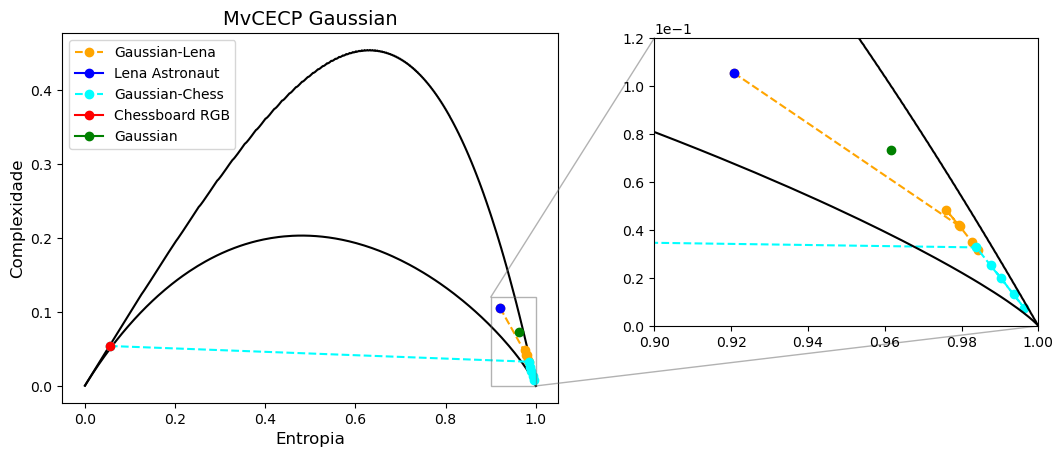

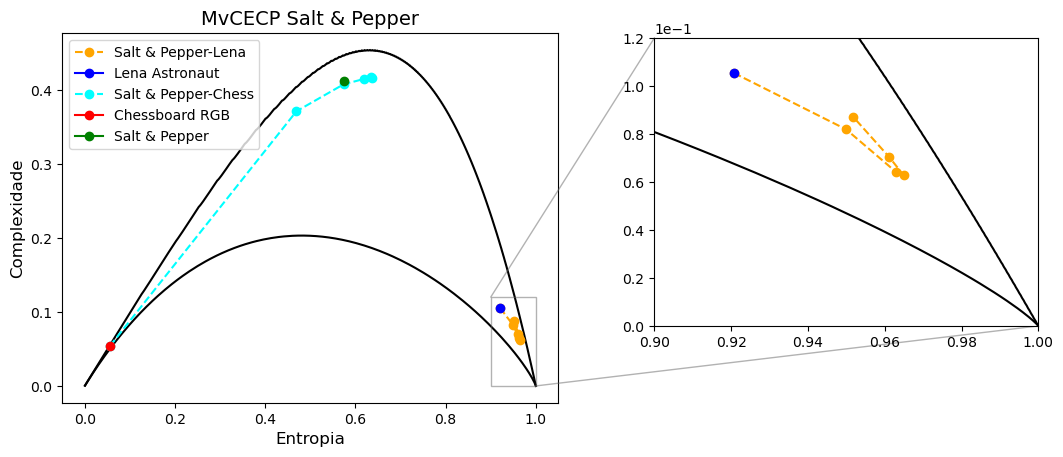

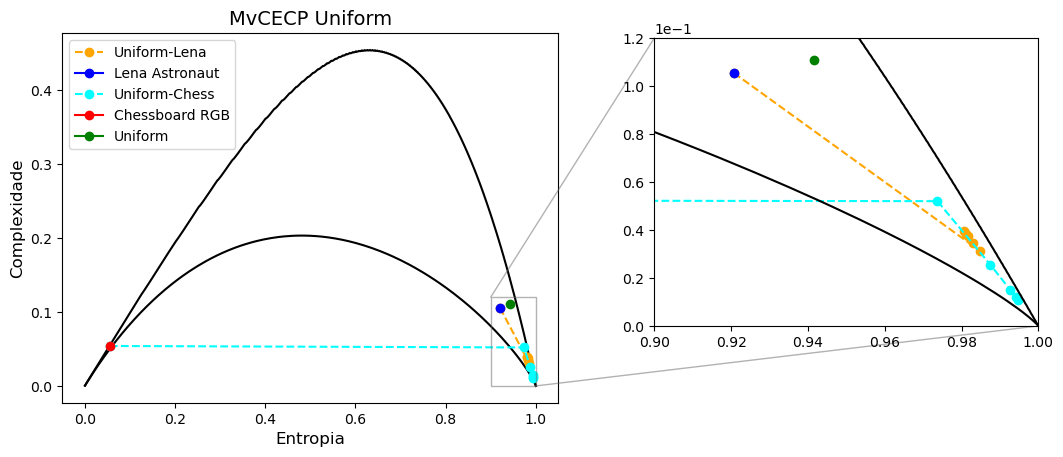

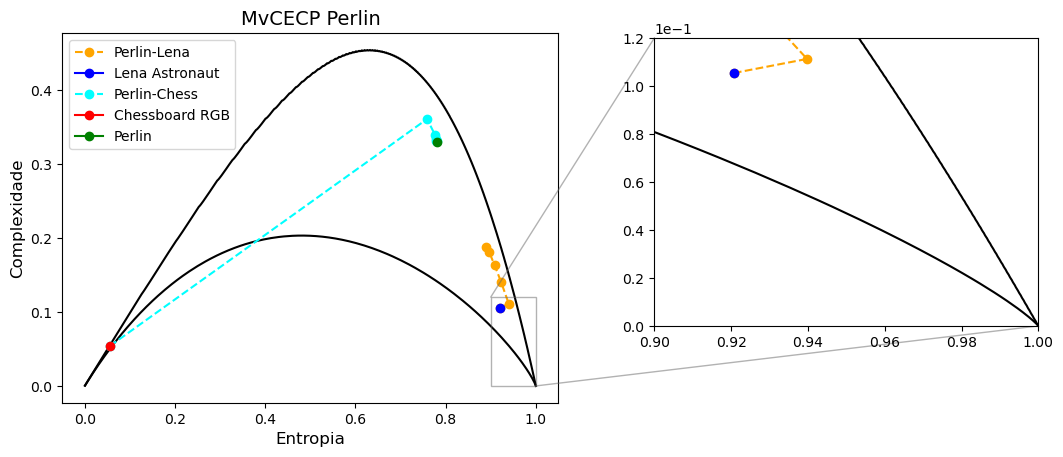

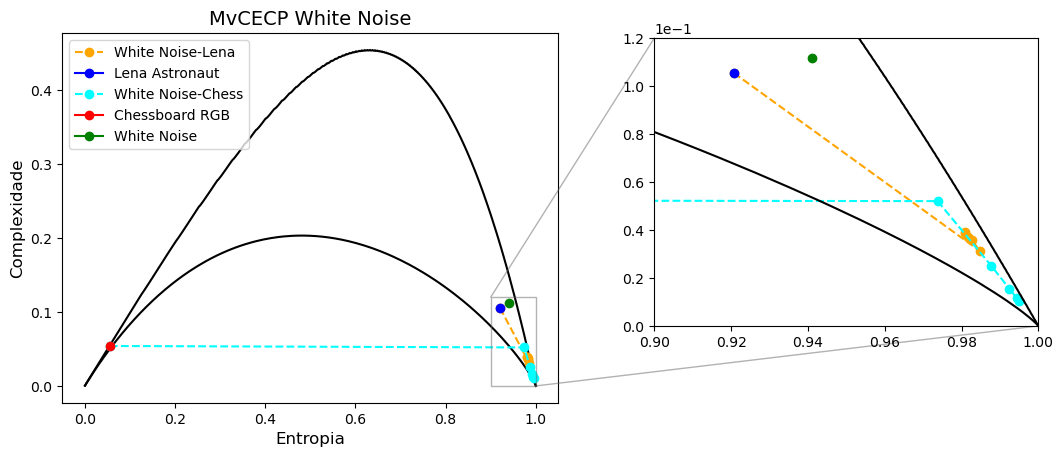

In [15]:
noises = list(noise_functions.keys())
    
# Loop para cada tipo de ruído
for i, noise in enumerate(noises):
    # Dados de entropia e complexidade para o ruído atual
    aux_ent_1 = [result["Entropy"] for result in results_1 if result["Noise Type"] == noise]
    aux_comp_1 = [result["Complexity"] for result in results_1 if result["Noise Type"] == noise]
        
    aux_ent_2 = [result["Entropy"] for result in results_2 if result["Noise Type"] == noise]
    aux_comp_2 = [result["Complexity"] for result in results_2 if result["Noise Type"] == noise]
    
    aux_ent_noise = [result["Entropy"] for result in results_noise if result["Noise Type"] == noise]
    aux_comp_noise = [result["Complexity"] for result in results_noise if result["Noise Type"] == noise]
    
    fig, ax_main = plt.subplots() #figsize=(10, 6)
        
    # Adicionar limites no gráfico principal
    bp.plot_3d(D)
    
    # Plot no gráfico principal
    ax_main.plot(aux_ent_1, aux_comp_1, marker='o', linestyle='--', label=noise+"-Lena", color='orange')
    ax_main.plot(ent_lena, comp_lena, marker='o', label='Lena Astronaut', color='blue')
    ax_main.plot(aux_ent_2, aux_comp_2, marker='o', linestyle='--', label=noise+"-Chess", color='cyan')
    ax_main.plot(ent_chess, comp_chess, marker='o', label="Chessboard RGB", color='red')
    ax_main.plot(aux_ent_noise, aux_comp_noise, marker='o', label=noise, color='green')
    
    # Configurações do gráfico principal
    ax_main.set_title(f"MvCECP {noise}", fontsize=14)
    ax_main.set_xlabel("Entropia", fontsize=12)
    ax_main.set_ylabel("Complexidade", fontsize=12)
    ax_main.legend(loc="upper left", fontsize=10)
    
    axins = plt.axes([1.05, 0.27, 0.6, 0.6])
    #axins = ax.inset_axes([1.2, 0.2, 0.8, 0.8])
    x1, x2, y1, y2 = 0.9, 1.0, 0.0, 0.12
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    #axins.set_xticklabels('')
    #axins.set_yticklabels('')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(x1, x2)) #x1,x2
    plt.ticklabel_format(style='sci', axis='y', scilimits=(y1, y2)) #y1,y2
    
    ax_main.indicate_inset_zoom(axins, edgecolor = '0.4')
    
    folder='./limits/mv/'
    M = 240

    df_cont = pd.read_csv(folder +'continua-N'+str(M)+'.q1', skiprows=20, sep = '  ', engine = 'python') #7
    df_cont.columns = ['HT', 'CJT']

    df_troz = pd.read_csv(folder +'trozos-N'+str(M)+'.q1', skiprows=20, sep = '  ', engine = 'python')
    df_troz.columns = ['HT', 'CJT']

    # Plot no gráfico principal
    axins.plot(aux_ent_1, aux_comp_1, marker='o', linestyle='--', label=noise+"-Lena", color='orange')
    axins.plot(ent_lena, comp_lena, marker='o', label='Lena Astronaut', color='blue')
    axins.plot(aux_ent_2, aux_comp_2, marker='o', linestyle='--', label=noise+"-Chess", color='cyan')
    axins.plot(ent_chess, comp_chess, marker='o', label="Chessboard RGB", color='red')
    axins.plot(aux_ent_noise, aux_comp_noise, marker='o', label=noise, color='green')

    axins.plot(df_cont['HT'], df_cont['CJT'], color='black')
    axins.plot(df_troz['HT'], df_troz['CJT'], color='black')
    
    plt.show()    